# PyTorch Dataset Building + Positive/Negative Pairing

The dataset was split into train and test from issue #5. Carrying on from there, a PyTorch dataset can be built to take in the dataframe and output a PyTorch dataset that has the positive and negative pairs.

## 1. Imports + Reading Dataframe

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_parquet("/home/danny/siamese-nn-facial-recognition/data/train.parquet")
test_data = pd.read_parquet("/home/danny/siamese-nn-facial-recognition/data/test.parquet")

In [4]:
train_data.head()

,person,num_photos,image_path
0,Alicia_Hollowell,1,../data/lfw-deepfunneled/lfw-deepfunneled/Alic...
1,Dwayne_Johnson,2,../data/lfw-deepfunneled/lfw-deepfunneled/Dway...
2,Dwayne_Johnson,2,../data/lfw-deepfunneled/lfw-deepfunneled/Dway...
3,Jim_Doyle,1,../data/lfw-deepfunneled/lfw-deepfunneled/Jim_...
4,Pierre_Lacroix,1,../data/lfw-deepfunneled/lfw-deepfunneled/Pier...


## 2. Max Number of Positive Pairs

As mentioned before, we will doing the pairing of the images within the PyTorch Dataset. Before we do so, let's find what the max number of positive pairs is so we can see roughly how many samples we have to work with. For this, we can use a simple combination formula nCr where `n` = number of images, and `r` is 2.

In [5]:
train_filtered = train_data[train_data['num_photos'] > 1]
train_filtered['positive_pairs'] = train_filtered['num_photos'].apply(lambda x: x * (x - 1) // 2)
train_filtered.drop_duplicates(subset=['person'], inplace=True)
train_positive_pairs = train_filtered['positive_pairs'].sum()

test_filtered = test_data[test_data['num_photos'] > 1]
test_filtered['positive_pairs'] = test_filtered['num_photos'].apply(lambda x: x * (x - 1) // 2)
test_filtered.drop_duplicates(subset=['person'], inplace=True)
test_positive_pairs = test_filtered['positive_pairs'].sum()


print(f"Total number of positive pairs in train set: {train_positive_pairs}\nTotal number of positive pairs in test set: {test_positive_pairs}")

Total number of positive pairs in train set: 229539
Total number of positive pairs in test set: 12718


Ok, we have 229,539 positive pairs in the training set and 12,718 in the test set. That's a decent number of samples. Note that the test set has a lot fewer pairs, we can look to increasing that if we need to. For now, we can start writing the PyTorch Dataset.

## 3. New Dataframe of Pairs

In [63]:
def get_pairs(data, positive_data):
    pair_dict = {'image1': [], 'image2': [], 'label': []}

    image1, image2, label = get_positive_pairs(positive_data)
    pair_dict['image1'].extend(image1)
    pair_dict['image2'].extend(image2)
    pair_dict['label'].extend(label)
    
    num_pairs = len(image1)
    print(f"Number of positive pairs: {num_pairs}")
    
    image1, image2, label = get_negative_pairs(data, num_pairs)
    pair_dict['image1'].extend(image1)
    pair_dict['image2'].extend(image2)
    pair_dict['label'].extend(label)
    
    return pair_dict
                    
def get_positive_pairs(data):
    image1, image2, label = [], [], []
    for person in tqdm(data['person'].unique()):
        person_df = data[data['person'] == person]
        for j in range(len(person_df)):
            for k in range(j + 1, len(person_df)):
                image1.append(person_df.iloc[j]['image_path'])
                image2.append(person_df.iloc[k]['image_path'])
                label.append(True) 
    print(f"Positive pairs: {len(image1)}")
    return image1, image2, label

def get_negative_pairs(data, num_pairs):
    image1, image2, label = [], [], []
    for person in tqdm(data['person'].unique()):
        for j, row in data.iterrows():
            for k, row in data.iterrows():
                if row['person'] != person:
                    image1.append(data.iloc[j]['image_path'])
                    image2.append(row['image_path'])
                    label.append(False)
                    if len(image1) == num_pairs:
                        print(f"Negative pairs: {len(image1)}")
                        return image1, image2, label

# def get_negative_pairs_2(data, num_pairs):
#     image1, image2, label = [], [], []
#     person_list = data['person'].unique()
    
#     while len(image1) < num_pairs:
#         # Randomly select two different people
#         person1, person2 = np.random.choice(person_list, 2, replace=True)
#         if person1 == person2:
#             continue
#         img1 = data[data['person'] == person1].sample()['image_path'].values[0]
#         img2 = data[data['person'] == person2].sample()['image_path'].values[0]
        
#         image1.append(img1)
#         image2.append(img2)
#         label.append(0)
        
#         print(f"Negative pairs: {len(image1)}")
        
#     return image1, image2, label


In [64]:
train_filtered = train_data[train_data['num_photos'] > 1]
train_pair_dict = get_pairs(train_data, train_filtered)

100%|██████████| 1338/1338 [00:17<00:00, 75.52it/s]  


Positive pairs: 831011
Number of positive pairs: 831011


  0%|          | 0/4593 [00:18<?, ?it/s]

Negative pairs: 831011


In [65]:
test_filtered = test_data[test_data['num_photos'] > 1]
test_pair_dict = get_pairs(test_data, test_filtered)

100%|██████████| 342/342 [00:00<00:00, 462.25it/s] 


Positive pairs: 34582
Number of positive pairs: 34582


  0%|          | 0/1156 [00:00<?, ?it/s]

Negative pairs: 34582


In [66]:
check = pd.DataFrame(train_pair_dict)

In [67]:
check

,image1,image2,label
0,../data/lfw-deepfunneled/lfw-deepfunneled/Dway...,../data/lfw-deepfunneled/lfw-deepfunneled/Dway...,True
1,../data/lfw-deepfunneled/lfw-deepfunneled/Rob_...,../data/lfw-deepfunneled/lfw-deepfunneled/Rob_...,True
2,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,True
3,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,True
4,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,../data/lfw-deepfunneled/lfw-deepfunneled/Jame...,True
...,...,...,...
1662017,../data/lfw-deepfunneled/lfw-deepfunneled/Kimi...,../data/lfw-deepfunneled/lfw-deepfunneled/Cour...,False
1662018,../data/lfw-deepfunneled/lfw-deepfunneled/Kimi...,../data/lfw-deepfunneled/lfw-deepfunneled/Cour...,False
1662019,../data/lfw-deepfunneled/lfw-deepfunneled/Kimi...,../data/lfw-deepfunneled/lfw-deepfunneled/Mich...,False
1662020,../data/lfw-deepfunneled/lfw-deepfunneled/Kimi...,../data/lfw-deepfunneled/lfw-deepfunneled/Mich...,False


## 3. PyTorch Dataset

In [74]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x1 = torch.tensor(plt.imread(self.data['image1'][idx]), dtype=torch.float)
        x2 = torch.tensor(plt.imread(self.data['image2'][idx]), dtype=torch.float)
        label = torch.tensor(self.data['label'][idx], dtype=torch.float)
        
        return x1, x2, label
        
        
        

In [75]:
dataset = SiameseDataset(check)

In [79]:
dataset[0][0]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [ ]:

class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, seed=42):
        self.df = df
        self.transform = transform
        self.person_to_images = df.groupby('person')['image_path'].apply(list).to_dict()
        self.person_list = list(self.person_to_images.keys())
        self.seed = seed
        
        # Set the seed for reproducibility
        random.seed(self.seed)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Pick a person and an image
        person = self.df.iloc[idx]['person']
        image_path1 = self.df.iloc[idx]['image_path']
        
        # Positive pair (same person)
        if self.df[self.df['person'] == person]['num_photos'].values[0] > 1:
            image_path2 = self.df[self.df['person'] == person].sample(n=1)['image_path']
            label = 1
        else:
            # Negative pair (different person)
            different_person = person
            while different_person == person:
                different_person = random.choice(self.person_list)
            image_path2 = random.choice(self.person_to_images[different_person])
            label = 0
        
        # Load images
        img1 = Image.open(image_path1).convert('RGB')
        img2 = Image.open(image_path2).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor([label], dtype=torch.float32)

In [ ]:
dataset = SiameseDataset(df = train_data)

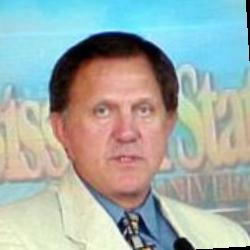

In [ ]:
dataset[3][1]